In [1]:
import sys
sys.path.append('../..')

import src


In [6]:
from src import WindSpeedUnit, HistoricalHourly, HistoricalAPI
import datetime as dt

f = HistoricalAPI()
dundalk_it = (53.98352, -6.391390) #https://data.mendeley.com/datasets/tm988rs48k/2
f.latitude, f.longitude = dundalk_it
f.wind_speed_unit = WindSpeedUnit.METERS_PER_SECOND
# f.current = [ForecastCurrent.WIND_SPEED_10M, ForecastCurrent.WIND_DIRECTION_10M, ForecastCurrent.TEMPERATURE_2M]
f.hourly = [HistoricalHourly.TEMPERATURE_2M,
            HistoricalHourly.RELATIVE_HUMIDITY_2M, 
            HistoricalHourly.PRECIPITATION,
            HistoricalHourly.WIND_SPEED_10M,
            HistoricalHourly.WIND_DIRECTION_10M,
            HistoricalHourly.WIND_SPEED_100M,
            HistoricalHourly.WIND_DIRECTION_100M]
f.start_date = dt.datetime(2000, 1, 1)
f.end_date = dt.datetime(2025, 2, 20) 

f.build_url()
result = f.request()


'https://archive-api.open-meteo.com/v1/archive?end_date=2025-02-20&hourly=temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m,wind_direction_10m,wind_speed_100m,wind_direction_100m&latitude=53.98352&longitude=-6.39139&start_date=2000-01-01&wind_speed_unit=ms'

In [20]:
for k,v in result.items():
    print(k,end = '')
    if isinstance(v, list):
        print('',v[:5],end='')
    elif isinstance(v, dict):
        print('',list(v.keys()),end='')
    else:
        print('',v,end='')
    print()

latitude 53.954304
longitude -6.4410095
generationtime_ms 9705.280303955078
utc_offset_seconds 0
timezone GMT
timezone_abbreviation GMT
elevation 15.0
hourly_units ['time', 'temperature_2m', 'relative_humidity_2m', 'precipitation', 'wind_speed_10m', 'wind_direction_10m', 'wind_speed_100m', 'wind_direction_100m']
hourly ['time', 'temperature_2m', 'relative_humidity_2m', 'precipitation', 'wind_speed_10m', 'wind_direction_10m', 'wind_speed_100m', 'wind_direction_100m']


In [7]:
import pandas as pd
import sqlite3
from copy import deepcopy

metadata = dict()
response = deepcopy(result)

for k,v in result.items():
    if not isinstance(v, (list,dict)):
        metadata[k] = response.pop(k)

df = pd.DataFrame(response['hourly'])
for k,v in metadata.items():
    if k == 'generationtime_ms':
        continue
    df[k] = v

df = df.dropna()

In [35]:
df.to_pickle('historical.pkl')

In [6]:
import pandas as pd
import sys
sys.path.append('../..')
import src

Raw_df = pd.read_pickle('historical.pkl')
df = Raw_df.copy()
df.time = pd.to_datetime(df.time,format = '%Y-%m-%dT%H:%M').astype('str')

# df.to_csv(src.SOURCE.DATA.str+'//historical_weather_data.csv',index = False)


In [17]:
import sqlite3

'''
time                       {'str': 220345}
temperature_2m           {'float': 220345}
relative_humidity_2m     {'float': 220345}
precipitation            {'float': 220345}
wind_speed_10m           {'float': 220345}
wind_direction_10m       {'float': 220345}
wind_speed_100m          {'float': 220345}
wind_direction_100m      {'float': 220345}
latitude                 {'float': 220345}
longitude                {'float': 220345}
utc_offset_seconds         {'int': 220345}
timezone                   {'str': 220345}
timezone_abbreviation      {'str': 220345}
elevation                {'float': 220345}
'''
df = Raw_df.copy()
df.time = pd.to_datetime(df.time,format = '%Y-%m-%dT%H:%M').astype('str')
df = df.melt(id_vars = 'time latitude longitude utc_offset_seconds timezone timezone_abbreviation elevation'.split(),
        value_vars = 'temperature_2m relative_humidity_2m precipitation wind_speed_10m wind_direction_10m wind_speed_100m wind_direction_100m'.split(),
        var_name = 'parameter',
        value_name = 'value')
# make sqlite file with the above fields and datatypes. Table name is historical weather data
conn = sqlite3.connect(src.SOURCE.DATA.DB.str)

cursor = conn.cursor()
# enable Write Ahead Logging (WAL) mode
cursor.execute("PRAGMA journal_mode=WAL;")

# make if not exists
# COMMAND = '''
# CREATE TABLE IF NOT EXISTS historical_weather_data (
#     ID INTEGER PRIMARY KEY AUTOINCREMENT,
#     time TEXT,
#     temperature_2m REAL,
#     relative_humidity_2m REAL,
#     precipitation REAL,
#     wind_speed_10m REAL,
#     wind_direction_10m REAL,
#     wind_speed_100m REAL,
#     wind_direction_100m REAL,
#     latitude REAL,
#     longitude REAL,
#     utc_offset_seconds INTEGER,
#     timezone TEXT,
#     timezone_abbreviation TEXT,
#     elevation REAL
# );
# '''
COMMAND = '''
CREATE TABLE IF NOT EXISTS hourly_historical_weather_data(
    ID INTEGER PRIMARY KEY AUTOINCREMENT,
    time TEXT,
    latitude REAL,
    longitude REAL,
    utc_offset_seconds INTEGER,
    timezone TEXT,
    timezone_abbreviation TEXT,
    elevation REAL
    parameter TEXT,
    value REAL
);
'''

cursor.execute(COMMAND)
conn.commit()


In [18]:
df.to_sql('hourly_historical_weather_data', conn, if_exists='replace', index = False)

1542415

<Axes: xlabel='time'>

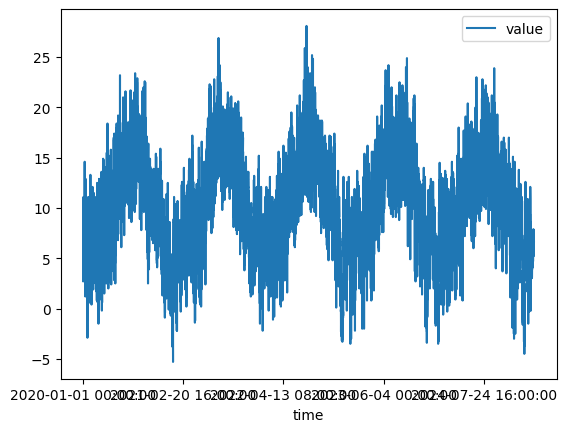